In [3]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline

In [2]:
# Load training data set
train = pd.read_json('../input/train.json')

In [3]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
def convert_to_one_hot(arr, c):
    one_hot_arr = np.zeros((c, arr.shape[1]), dtype=np.int8)
    for i in range(arr.shape[1]):
        one_hot_arr[arr[0,i],i] = 1
    return one_hot_arr

In [5]:
y = np.array([[0,1,0,1,1,1]])
print(y)
print(convert_to_one_hot(y,2))

[[0 1 0 1 1 1]]
[[1 0 1 0 0 0]
 [0 1 0 1 1 1]]


In [6]:
train_flatten = np.array(train['band_1'].tolist())
train_x = train_flatten.transpose()
y = np.array(train['is_iceberg'].tolist()).reshape(1,-1)
train_y = convert_to_one_hot(y,2)
print(train_x.shape)
print(train_y.shape)

(5625, 1604)
(2, 1604)


In [7]:
test = pd.read_json('../input/test.json')

In [8]:
test.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


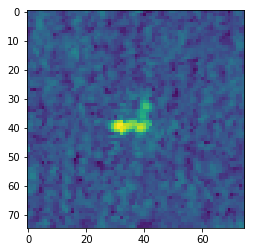

In [9]:
raw = np.array(train.iloc[1]['band_1'])
raw = raw.reshape((75,75))
plt.imshow(raw)

In [10]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, name='X', shape=[n_x, None])
    Y = tf.placeholder(tf.float32, name='Y', shape=[n_y, None])
    return X, Y

In [11]:
X, Y = create_placeholders(10, 1)
print(X, Y)

Tensor("X:0", shape=(10, ?), dtype=float32) Tensor("Y:0", shape=(1, ?), dtype=float32)


In [12]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [2, 12]
                        b3 : [2, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [25,5625], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12, 1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2, 12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [2, 1], initializer=tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [13]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 5625) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


In [14]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                                              # Z3 = np.dot(W3,Z2) + b3
    A3 = tf.nn.sigmoid(Z3)
    ### END CODE HERE ###
    
    return Z3

In [15]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(75*75, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(2, ?), dtype=float32)


In [16]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits=logits))
    ### END CODE HERE ###
    
    return cost

In [17]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(75*75, 1)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [18]:
print(type(train_x))
tmp_X = train_x.copy()

<class 'numpy.ndarray'>


In [19]:
tmp1 = np.array([])

In [20]:
def random_mini_batches(X, Y, mini_batch_size):
    tmp_X = X.copy()
    tmp_Y = Y.copy()
    while(tmp_X.shape[1]>0):
        pick_size = tmp_X.shape[1] if tmp_X.shape[1]<mini_batch_size else mini_batch_size
        mini_batch_x = None
        mini_batch_y = None
        for _ in range(pick_size):
            pick_num = int(np.ceil(np.random.rand() * tmp_X.shape[1]))-1
            if mini_batch_x is None:
                mini_batch_x = tmp_X[:,pick_num].reshape(X.shape[0],-1)
                mini_batch_y = tmp_Y[:,pick_num].reshape(Y.shape[0],-1)
            else:
                mini_batch_x = np.concatenate((mini_batch_x, tmp_X[:,pick_num].reshape(X.shape[0],-1)), axis=1)
                mini_batch_y = np.concatenate((mini_batch_y, tmp_Y[:,pick_num].reshape(Y.shape[0],-1)), axis=1)
            tmp_X = np.delete(tmp_X, pick_num, axis=1)
            tmp_Y = np.delete(tmp_Y, pick_num, axis=1)
        yield mini_batch_x, mini_batch_y

In [21]:
sample_x = np.array([[1,2,3],[4,5,6],[7,8,9]])
sample_y = np.array([[1,0,1],[1,1,0],[0,1,1]])
get_mini_batches = random_mini_batches(sample_x, sample_y,2)


In [22]:
print(next(get_mini_batches))

(array([[3, 2],
       [6, 5],
       [9, 8]]), array([[1, 0],
       [0, 1],
       [1, 1]]))


In [23]:
order_id = np.random.rand(1, train_x.shape[1])
print(order_id + train_x)

[[-27.37460877 -11.38411421 -23.62795249 ..., -17.98083555 -21.99232224
  -19.37793242]
 [-26.65040777 -14.06204421 -23.62799049 ..., -17.98078455 -25.33135024
  -20.14714742]
 [-28.16486277 -14.06210221 -23.89530549 ..., -18.85631055 -26.49125624
  -19.67757542]
 ..., 
 [-26.31327977 -10.22929821 -20.93719049 ..., -15.68975055 -19.18239124
  -16.95760642]
 [-27.37823077  -7.38842321 -21.53649149 ..., -17.07446955 -19.04985024
  -17.41491242]
 [-27.76437477  -7.80854021 -24.17428149 ..., -18.21895155 -18.66381624
  -16.73779742]]


In [24]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1000, minibatch_size = 16, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for i_minibatch in range(num_minibatches):

                # Select a minibatch
                (minibatch_X, minibatch_Y) = next(minibatches)
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches
#                 if i_minibatch % 10 == 0:
#                     print("Cost after minibatch {}: {}".format(i_minibatch, minibatch_cost))

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        # print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.042746
Cost after epoch 100: 0.379145
Cost after epoch 200: 0.219669
Cost after epoch 300: 0.110296
Cost after epoch 400: 0.016675
Cost after epoch 500: 0.013797
Cost after epoch 600: 0.007201
Cost after epoch 700: 0.697591
Cost after epoch 800: 0.691291
Cost after epoch 900: 0.691213


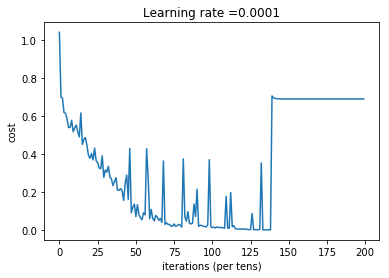

Parameters have been trained!
Train Accuracy: 0.530549


In [25]:
parameters = model(train_x, train_y, train_x, train_y)

In [12]:
a = np.array([[[-0.3224172,  -0.38405435,  1.13376944],
    [-1.09989127, -0.17242821, -0.87785842]],
    [[ 0.90085595, -0.68372786, -0.12289023],
    [-0.93576943, -0.26788808,  0.53035547]]])
w = np.array([[[ 0.5924728,   0.45194604,  0.057121],
            [ 0.55607351,  0.55743945,  0.71304905]],
             [[ 0.38271517, -0.73153098, -1.15498263],
            [ 1.47016034,  3.9586027,   1.85300949]]])
res = np.multiply(a , w)

In [13]:
res.shape

(2, 2, 3)

In [14]:
np.sum(res)-0.6294416

-2.72953404838408